In [3]:
import torch.nn as nn
import torch
from functorch import vmap,jacrev
from scipy.integrate import solve_ivp

class Operator_Module(nn.Module):
    def __init__(self):
        super().__init__()
        pass


class DeepONet(Operator_Module):
    def __init__(self,branch_net : nn.Module, trunk_net:nn.Module):
        super().__init__()
        self.branch_net = branch_net
        self.trunk_net = trunk_net
        self.b = None

    def set_branch(self,x):
        self.b = self.branch_net(x)

    def query_point(self,x):
        return torch.matmul(self.b,torch.moveaxis(self.trunk_net(x),0,1))

    def forward(self,u,y):
        b = self.branch_net(u)
        t = torch.transpose(self.trunk_net(y),0,1)
        G = torch.matmul(b,t)
        return G




In [4]:
f = lambda t,y: t

sol = solve_ivp(f,t_span =(0,4),y0 = [0],t_eval = torch.linspace(0,4,10))

In [5]:
from matplotlib import pyplot as plt

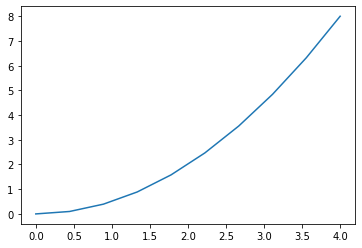

In [6]:
plt.plot(sol.t,sol.y[0])

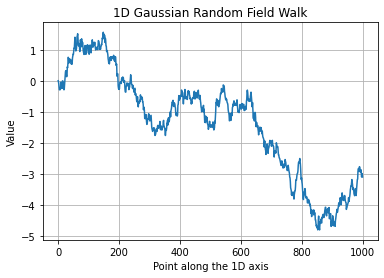

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
num_points = 1000  # Number of points along the 1D axis
mean = 0.0         # Mean of the Gaussian distribution
std_dev = 0.1      # Standard deviation of the Gaussian distribution

# Generate random increments from a Gaussian distribution
increments = np.random.normal(mean, std_dev, num_points)

# Calculate the cumulative sum of increments to get the field
field = np.cumsum(increments)

# Plot the Gaussian random field walk
plt.plot(field)
plt.title("1D Gaussian Random Field Walk")
plt.xlabel("Point along the 1D axis")
plt.ylabel("Value")
plt.grid(True)
plt.show()


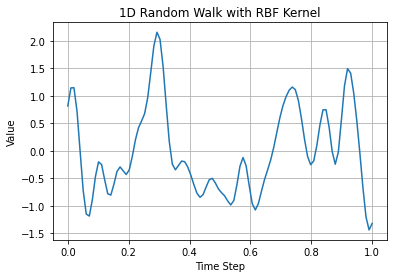

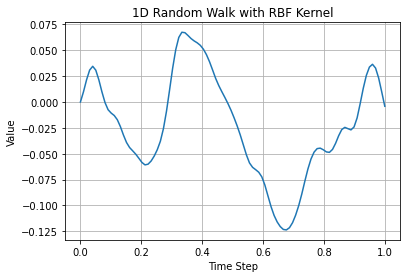

In [8]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d 
# Define the number of points in the random walk
num_points = 100

# Create an array of x-values (time steps)
x = np.linspace(0, 1, num_points)

# Define the RBF kernel with a specific length scale (sigma)
kernel = 1.0 * RBF(length_scale=1)

# Create the Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Sample from the GP to generate the random walk
y_samples = gp.sample_y(np.reshape(x, (-1, 1)), random_state=None)



def GRW(t_eval,l=1,random_state = None):
    # Define the RBF kernel with a specific length scale (sigma)
    kernel = 1.0 * RBF(length_scale=l)
    # Create the Gaussian Process model
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    y = gp.sample_y(np.reshape(t_eval, (-1, 1)), random_state=random_state)[:,0]
    
    interp_func = interp1d(t_eval,y)
    def inner_func(t,y=None):
        return interp_func(t)

    return inner_func


x = np.linspace(0, 1, num_points)
rand_f = GRW(x,random_state=None,l = 0.03)

# rand_f = lambda x,y = None: 0.001*np.exp(x)
y_samples = rand_f(x)
sol = solve_ivp(rand_f,t_span =(0,1),y0 = [0],t_eval = x)

# Plot the random walk
plt.plot(x, y_samples)
plt.title("1D Random Walk with RBF Kernel")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.show()

# Plot the random walk
sol = solve_ivp(rand_f,t_span =(0,1),y0 = [0],t_eval = x)

plt.plot(x, sol.y[0])
plt.title("1D Random Walk with RBF Kernel")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.show()



In [71]:
#Create Data

t_span = (0,1)
num_points = 20
t = torch.linspace(*t_span,num_points)


u_funcs  = [GRW(t,l = 0.03) for _ in range(20)]
s_data = [solve_ivp(rand_f,t_span =t_span,y0 = [0],t_eval = t).y[0] for rand_f in u_funcs]

In [72]:
u_data = np.array([u_func(t) for u_func in u_funcs])
s_data = np.array(s_data)

u_data = torch.from_numpy(u_data).to(dtype = torch.float32)
s_data = torch.from_numpy(s_data).to(dtype = torch.float32)

In [73]:
s_data.shape,u_data.shape

(torch.Size([20, 20]), torch.Size([20, 20]))

In [74]:
from src.continuous.Networks import MLP

In [92]:
branch = MLP(num_points,50,50,2,activation='tanh')
trunk  = MLP(1,50,50,2,activation='tanh')

ONet = DeepONet(branch,trunk)


# t_test = torch.linspace(0,4,7).unsqueeze(-1)
# u_test = torch.from_numpy(u_data)[0:10,:].to(dtype=torch.float32)

# t_test.shape,u_test.shape


In [93]:
x = t.unsqueeze(-1)
x.shape,s_data.shape

(torch.Size([20, 1]), torch.Size([20, 20]))

In [94]:
optimiser = torch.optim.Adam(ONet.parameters(),lr = 1e-3)
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser,threshold=1e-5,factor=0.90,threshold_mode='rel',patience=25)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser,gamma =0.9)

def wrapped_func(net):

    def inner_func(u,y):
        out = net(u,y)
        return out,out
    return inner_func

aux_func = wrapped_func(ONet)

jac_out = jacrev(aux_func,argnums=1,has_aux=True)
grads,G = jac_out(u_data,x)

#First dim is u_n, 2nd is query point, 3rd is derivative
d = torch.stack([torch.diagonal(grad) for grad in grads.squeeze()])
d.shape,G.shape

(torch.Size([20, 20]), torch.Size([20, 20]))

In [95]:

for epoch in range(10000):
    optimiser.zero_grad()
    # G = ONet(u_data,x)
    grads,G = jac_out(u_data,x)
    op_loss = (G-s_data).pow(2).mean()
    derivs = torch.stack([torch.diagonal(grad) for grad in grads.squeeze()])
    pi_loss = (derivs-u_data).pow(2).mean()
    # pi_loss = 0
    loss = op_loss + pi_loss
    if (epoch % 1000) == 0 and (epoch > 4000):
        lr_scheduler.step()
    loss.backward()
    optimiser.step()
    print(f'Epoch={epoch} Loss={float(loss)} lr={optimiser.param_groups[0]["lr"] }')
    

Epoch=0 Loss=1.0366488695144653 lr=0.001
Epoch=1 Loss=0.9898080229759216 lr=0.001
Epoch=2 Loss=0.9728540778160095 lr=0.001
Epoch=3 Loss=0.9618330597877502 lr=0.001
Epoch=4 Loss=0.948401689529419 lr=0.001
Epoch=5 Loss=0.9329044222831726 lr=0.001
Epoch=6 Loss=0.9173747301101685 lr=0.001
Epoch=7 Loss=0.9041194915771484 lr=0.001
Epoch=8 Loss=0.8955884575843811 lr=0.001
Epoch=9 Loss=0.8923189043998718 lr=0.001
Epoch=10 Loss=0.8910585641860962 lr=0.001
Epoch=11 Loss=0.8878290057182312 lr=0.001
Epoch=12 Loss=0.8820961713790894 lr=0.001
Epoch=13 Loss=0.8756160736083984 lr=0.001
Epoch=14 Loss=0.8698903918266296 lr=0.001
Epoch=15 Loss=0.8653700351715088 lr=0.001
Epoch=16 Loss=0.861590564250946 lr=0.001
Epoch=17 Loss=0.8575038313865662 lr=0.001
Epoch=18 Loss=0.8521960377693176 lr=0.001
Epoch=19 Loss=0.8457635641098022 lr=0.001
Epoch=20 Loss=0.8391553163528442 lr=0.001
Epoch=21 Loss=0.8328295946121216 lr=0.001
Epoch=22 Loss=0.827149510383606 lr=0.001
Epoch=23 Loss=0.82362961769104 lr=0.001
Epoch=2

KeyboardInterrupt: 

In [96]:

f = lambda t,y,n=1: np.cos(n*t)

xx = torch.linspace(*t_span,num_points)
test = xx.unsqueeze(-1)

sol = solve_ivp(f,t_span =t_span,y0 = [0],t_eval = xx)

In [97]:
# u_t = xx.unsqueeze(0)
u_t = torch.tensor(f(xx,0)).unsqueeze(0)
u_t.shape,test.shape

C:\Users\johnc\AppData\Local\Temp\ipykernel_6836\3018961333.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_t = torch.tensor(f(xx,0)).unsqueeze(0)


(torch.Size([1, 20]), torch.Size([20, 1]))

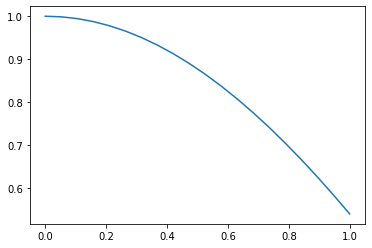

In [98]:
plt.plot(xx,u_t[0,:])

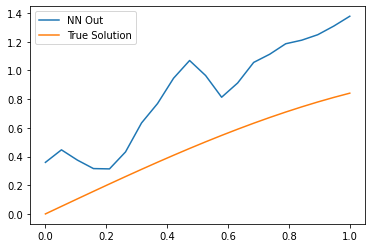

In [99]:
with torch.no_grad():
    out = ONet(u_t,test)

plt.plot(xx,out[0,:],label = 'NN Out')
plt.plot(xx,sol.y[0],label = 'True Solution')
plt.legend()

In [423]:
rand_f = GRW(xx,random_state=None,l = 0.09)

# rand_f = lambda x,y = None: 0.001*np.exp(x)
y_samples = rand_f(xx)
sol = solve_ivp(rand_f,t_span =(0,1),y0 = [0],t_eval = xx)



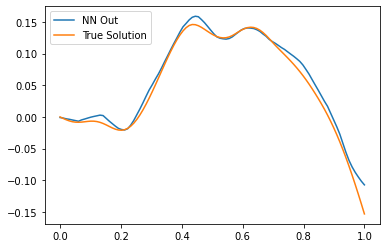

In [424]:
u_d = torch.from_numpy(y_samples).to(dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    out = ONet(u_d,test)

plt.plot(xx,out[0,:],label = 'NN Out')
plt.plot(xx,sol.y[0],label = 'True Solution')
plt.legend()

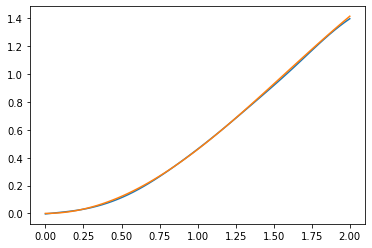

In [195]:
out = ONet(u_t,test)

xx = np.linspace(*t_span,num_points)
plt.plot(test[:,0].detach(),out[0,:].detach())
# plt.plot(xx,1/6*xx**3)
plt.plot(xx,sol.y[0])